In [1]:
#%cd ../../FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/

## Analysis on FIA-MS data after SmartPeak processing
#### This script is based on the assumption that mass ranges and pos/neg have already been merged. Triplicates will be taken care of by only keeping metabolites that were detected in all three of them.

#### Blanks have not fully been taken care of as of yet, they're just processed like regular runs

#### Imports (a bit excessive but did not weed out the important ones yet

In [2]:
import pymzml
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statistics
import csv
import pickle
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import copy

import matplotlib.colors
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
from mpl_toolkits.mplot3d import Axes3D

from pandas.errors import EmptyDataError

import seaborn as sns
from collections import defaultdict

import xml.etree.ElementTree as ET

from pyopenms import *


Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


## Process HMDB entries from file

In [3]:
HMDB2StructMapping = pd.read_csv("/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/CHEMISTRY/HMDB2StructMapping.tsv", 
                                 sep="\t", header=None)

In [4]:
SerumTop10 = pd.read_csv("/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/traML.csv", 
                                 sep="\,", header=None, engine='python')
SerumTop10 = list(SerumTop10.iloc[:,0])[1:]

# Functions

In [5]:
def extract_names_and_intensity(path_to_featureXML_dir, database_name_array):
    wd = path_to_featureXML_dir
    
    filenames_list = []
    for (dirpath, dirnames, filenames) in os.walk(wd):
        filenames_list.extend(filenames)
        break
    sorted_filenames_list = sorted(filenames_list)
    
    timestep_alldata = {}
    for file in sorted_filenames_list:
        features = FeatureMap()
        FeatureXMLFile().load(wd + "/" + file, features)
        extracted_data = {}
        for f in features:
            if f.getMetaValue("PeptideRef").decode("utf-8") in database_name_array:
                extracted_data[f.getMetaValue("PeptideRef").decode("utf-8")] = (f.getMetaValue("peak_apex_int"))
        extracted_data_df = pd.DataFrame(extracted_data.items(), columns=['Metabolite', 'Intensity'])
        timestep_alldata[file] = extracted_data_df
    
    return timestep_alldata

In [6]:
def calculate_mean_and_variance(extracted_info, txt_output_name):
    stats_of_files = {}
    for file_n in range(0, len(extracted_info), 3):
        stats_of_compound = pd.DataFrame(columns = ['Metabolite', 'Mean', 'Variance', 'Rel_Stdv'])
        file = list(extracted_info.items())
        for metabolite_n in range(0, len(file[file_n][1])):
            if file[file_n][1]['Metabolite'][metabolite_n] in \
            list(file[file_n + 1][1]['Metabolite']) and \
            file[file_n][1]['Metabolite'][metabolite_n] in \
            list(file[file_n + 2][1]['Metabolite']):
                file_1 = file[file_n][1]
                file_2 = file[file_n + 1][1]
                file_3 =  file[file_n + 2][1]

                index_2 = list(file_2['Metabolite']).index(file_1['Metabolite'][metabolite_n])
                index_3 = list(file_3['Metabolite']).index(file_1['Metabolite'][metabolite_n])
                
                mean_of_compound = statistics.mean([file_1['Intensity'][metabolite_n],\
                                                  file_2['Intensity'][index_2],\
                                                  file_3['Intensity'][index_3]])
                variance_of_compound = statistics.variance([file_1['Intensity'][metabolite_n],\
                                                           file_2['Intensity'][index_2],\
                                                           file_3['Intensity'][index_3]])
                relstdev_of_compound = np.sqrt(variance_of_compound) / mean_of_compound
                
                stats = pd.DataFrame([[file_1['Metabolite'][metabolite_n], mean_of_compound, variance_of_compound, relstdev_of_compound]],\
                                    columns = ['Metabolite', 'Mean', 'Variance', 'Rel_Stdv'])
                stats_of_compound = stats_of_compound.append(stats, ignore_index = True)
        stats_of_files[file[file_n][0][:-13]] = stats_of_compound
        
    with open(txt_output_name, 'wb') as handle:
        pickle.dump(stats_of_files, handle)
    #return stats_of_files

## Define working directory

In [10]:
wd = "/Users/matmat/Documents/FIA-MS/20201007_FIA_MS_metk/20201007_FIA_MS_metk/"

## Process samples compared to the full HMDataBase (this will take a while)

In [11]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "features_HMDB_60sec", HMDB2StructMapping[0].unique()), wd + "Results/features_HMDB_60sec.txt")

## Process samples compare to the top 10 serum metabolites

In [12]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "features_HMDB_60sec", np.array(SerumTop10, dtype = object)), wd + "Results/SerumTop10features_HMDB_60sec.txt")

# Import generated data
#### This step is separate in order to be able to jump back in without having to process everything again

In [13]:
with open(wd + "Results/features_HMDB_60sec.txt", 'rb') as handle:
    features_HMDB_60sec = pickle.loads(handle.read())

In [60]:
with open(wd + "Results/SerumTop10features_HMDB_60sec.txt", 'rb') as handle:
    SerumTop10features_HMDB_60sec = pickle.loads(handle.read())

#### Group files (select which wants you want to plot)

In [61]:
#stats_files = [features_30sec, features_60sec, features_90sec, features_180sec] 

In [62]:
stats_files = [SerumTop10features_HMDB_60sec] 

In [63]:
translate = {}
for file in stats_files:
    for key in file.keys():
        translate[key] = key[:-22]
    for old, new in translate.items():
        file[new] = file.pop(old)

In [64]:
for file in stats_files:
    for key in file.keys():
        print(key)

ISO_Water_AMF_pH3_20201007_Blank_HighMass_POS_1
ISO_Water_AMF_pH3_20201007_Blank_LowMass_POS_1
ISO_Water_AMF_pH3_20201007_C_elegans_x100Dilute_HighMass_POS_1
ISO_Water_AMF_pH3_20201007_C_elegans_x100Dilute_LowMass_POS_1
ISO_Water_AMF_pH3_20201007_C_elegans_x10Dilute_HighMass_POS_1
ISO_Water_AMF_pH3_20201007_C_elegans_x10Dilute_LowMass_POS_1
ISO_Water_AMF_pH3_20201007_C_elegans_x1Dilute_HighMass_POS_1
ISO_Water_AMF_pH3_20201007_C_elegans_x1Dilute_LowMass_POS_1
ISO_Water_AMF_pH3_20201007_C_elegans_x50Dilute_HighMass_POS_1
ISO_Water_AMF_pH3_20201007_C_elegans_x50Dilute_LowMass_POS_1
ISO_Water_AMF_pH3_20201007_C_elegans_x5Dilute_HighMass_POS_1
ISO_Water_AMF_pH3_20201007_C_elegans_x5Dilute_LowMass_POS_1
ISO_Water_AMF_pH3_20201007_HighMass_POS_CMmix_1_CM1
ISO_Water_AMF_pH3_20201007_HighMass_POS_CMmix_1_Levle10
ISO_Water_AMF_pH3_20201007_HighMass_POS_CMmix_1_Levle13
ISO_Water_AMF_pH3_20201007_HighMass_POS_CMmix_1_Levle1
ISO_Water_AMF_pH3_20201007_HighMass_POS_CMmix_1_Levle4
ISO_Water_AMF_pH3_

In [12]:
"""
collection = []
i = 0
for files in stats_files:
    new_dict = {}
    for keys in files.keys():
        if '1900-01-01_0000' not in keys:
            new_dict[keys] = stats_files[i][keys]
    collection.append(new_dict)
    i += 1
stats_files = collection
"""

In [13]:
"""
for file in stats_files:
    for each in file:
        file[each]['Rel_Stdv'] = np.sqrt(file[each]['Variance'])/file[each]['Mean']
"""

In [254]:
"""
from tabulate import tabulate

file_names = ['features_30sec', 'features_60sec', 'features_90sec', 'features_180sec'] 
j = 0
for file in stats_files:
    #print(str(file_names[j]))
    for i in file:
        #print(str(i))
        print(tabulate(file[i], headers='keys'))
    j += 1
"""

Metabolite    Mean    Variance    Rel_Stdv
------------  ------  ----------  ----------
Metabolite    Mean    Variance    Rel_Stdv
------------  ------  ----------  ----------
    Metabolite          Mean     Variance    Rel_Stdv
--  ----------------  ------  -----------  ----------
 0  HMDB:HMDB0000122  183801  2.32818e+08   0.0830157
 1  HMDB:HMDB0000641  116919  5.17576e+08   0.194582
    Metabolite                    Mean     Variance    Rel_Stdv
--  ----------------  ----------------  -----------  ----------
 0  HMDB:HMDB0000122  345518            1.95375e+10    0.404543
 1  HMDB:HMDB0000182       2.54143e+06  3.57739e+12    0.744228
 2  HMDB:HMDB0000641       2.60534e+06  6.39798e+12    0.97086
    Metabolite          Mean     Variance    Rel_Stdv
--  ----------------  ------  -----------  ----------
 0  HMDB:HMDB0000122  164795  2.28481e+09    0.290055
    Metabolite                    Mean     Variance    Rel_Stdv
--  ----------------  ----------------  -----------  ----------


In [260]:
"""
import fpdf

pdf = fpdf.FPDF(format='letter')
pdf.add_page()
pdf.set_font("Arial", size=12)

file_names = ['SerumTop10_30sec', 'SerumTop10_60sec', 'SerumTop10_90sec', 'SerumTop10_180sec'] 
#file_names = ['features_30sec', 'features_60sec', 'features_90sec', 'features_180sec'] 

j = 0
for file in stats_files:
    pdf.write(5,str(file_names[j]))
    pdf.ln()
    for i in file:
        pdf.write(5,str(i))
        pdf.ln()
        pdf.write(5,tabulate(file[i], headers='keys'))
        pdf.ln()
    pdf.output(str(file_names[j]) + ".pdf")
    j += 1
"""

#### Define parameters depending on what has been done and the naming convention

In [19]:
sample_types = ['Blank', 'C_elegans', '', 'Plate1', 'Plate2', 'Plate3']
settings = ['NewSourceSettings', 'OldSourceSettings']
solvents = ['MeOH_Water_0p1FA', 'ISO_Water_AMF_pH3']
methods = ['LH', 'M_0_2sWaste', 'M_0_4sWaste', 'M', 'M_HighInjSpeed_0_2sWaste',
          'M_HighInjSpeed_0_4sWaste', 'M_HighInjSpeed']
charges = ['POS', 'NEG']
CMmix_1 = ['CMmix_1']
levels = ['Levle' + str(x) for x in range(1, 16)]
dilutions = ['x1Dilute', 'x5Dilute', 'x10Dilute', 'x50Dilute', 'x100Dilute']
masses = ['HighMass', 'LowMass']
#times = [30, 60, 90, 180]
dates = ['20201007']

#### This step is optional, I added it when I had everything in one folder. In general, it is advised to put the processed files into a different folder than the "raw" data

## Plotting. Make sure that the naming convention is also applicable here
#### If you want to export the plots, uncomment the last line and adjust the name

Blank
POS


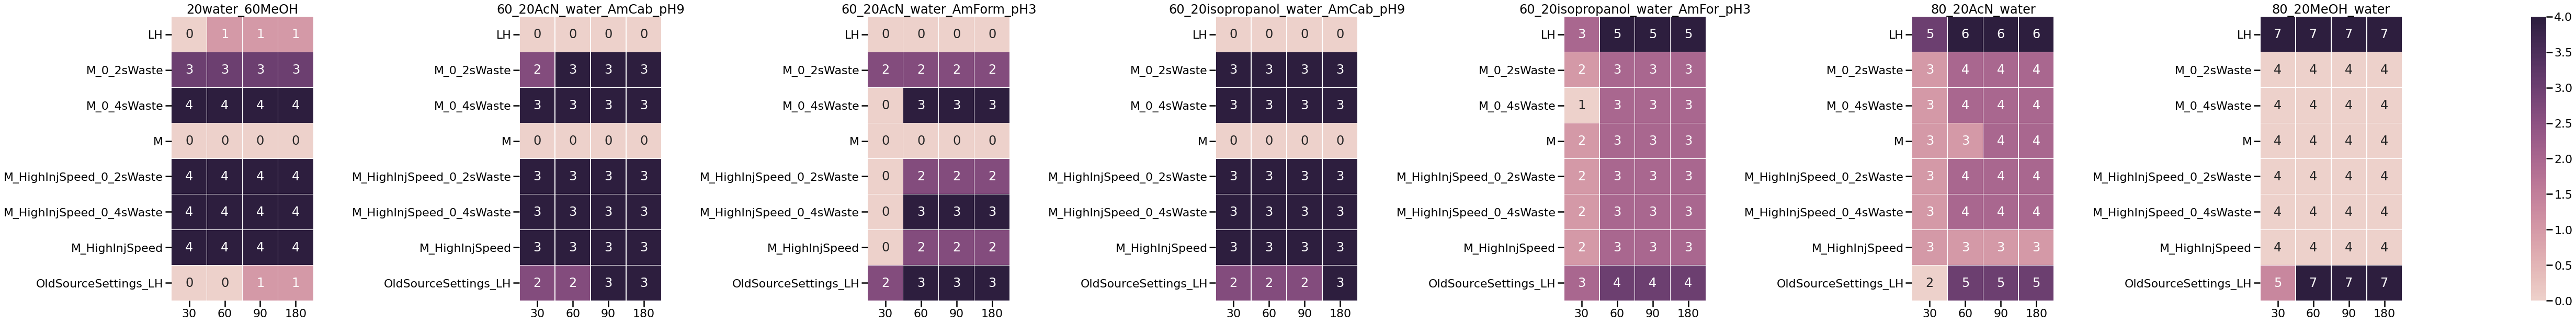

NEG


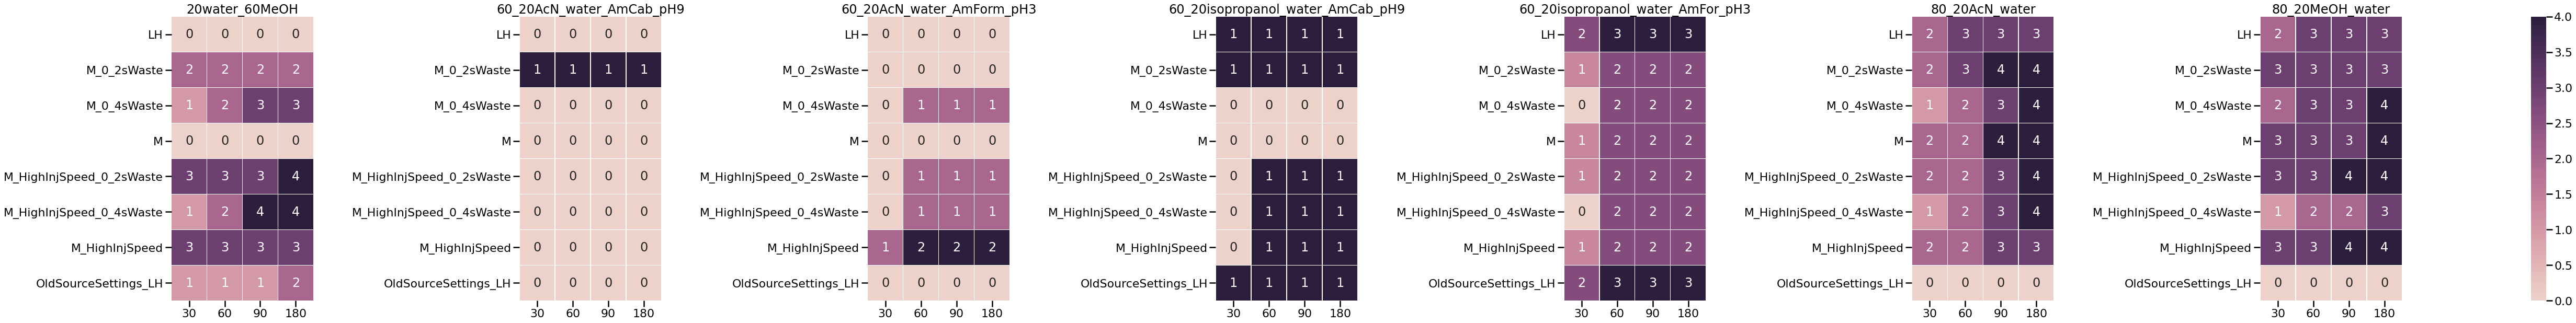

QCserum
POS


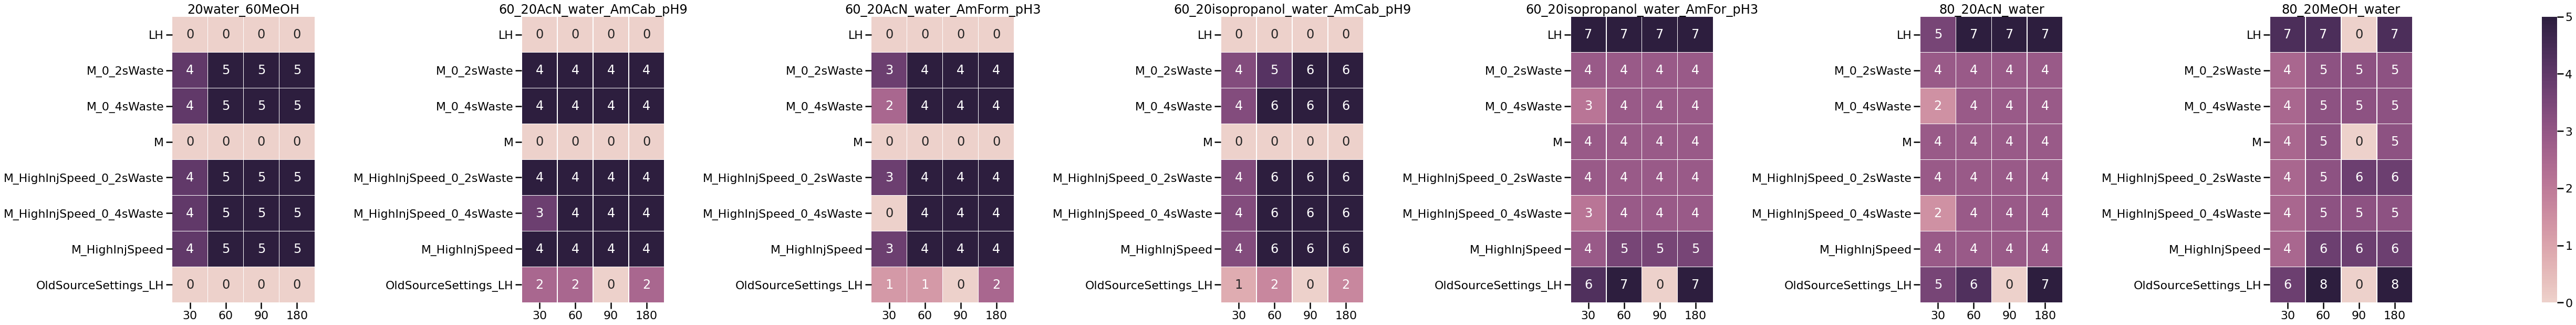

NEG


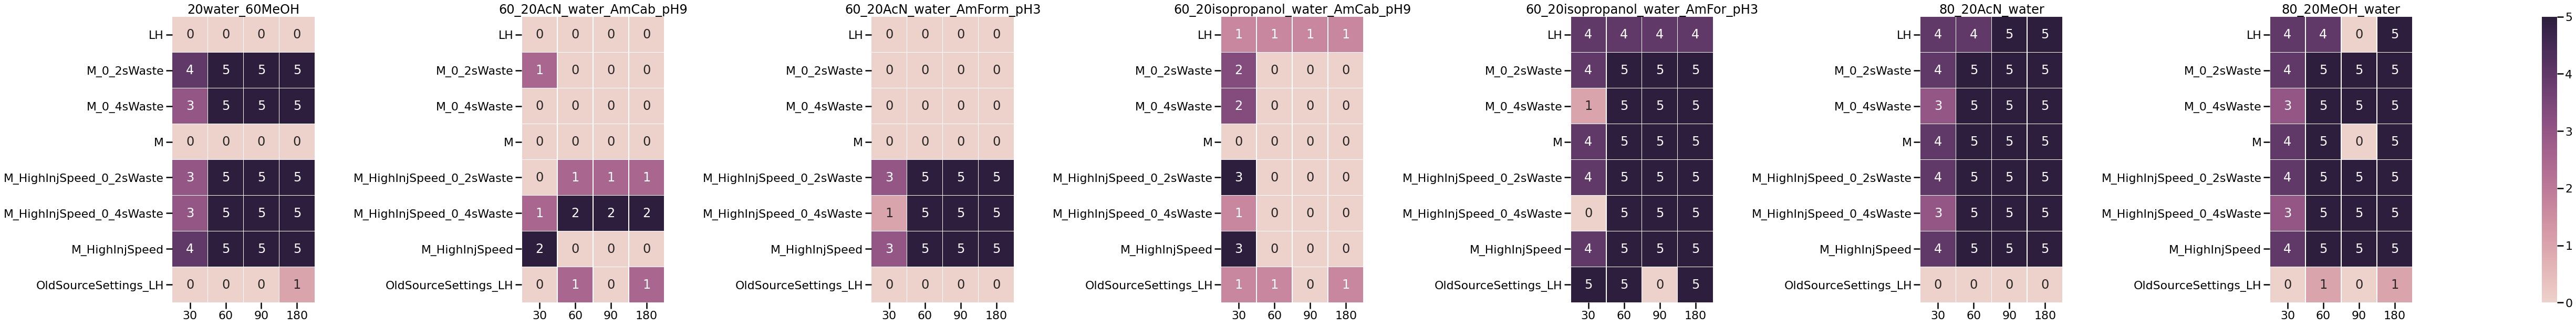

In [16]:
for sample_type in sample_types:
    print(sample_type)
    for charge in charges:
        print(charge)
        sns.set_context("poster")
        f, axs = plt.subplots(1, int((len(solvents) + 1)), figsize=(12*len(solvents), 10), gridspec_kw={'width_ratios': [10]*len(solvents) + [0.5]})
        cmap = sns.cubehelix_palette(as_cmap=True, n_colors=200)
        i = 0
        for solvent in solvents:
            df_heat = pd.DataFrame(index=methods + ['OldSourceSettings_LH'], columns=times)
            for method in methods:
                for setting in settings:
                    if setting == 'NewSourceSettings':
                        j = 0
                        for file in stats_files:
                            a = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + method + '_' + charge
                            df_heat.loc[method, times[j]] = len(file[a])
                            j += 1
                    else:
                        j = 0
                        for file in stats_files:
                            b = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + methods[0] + '_' + charge
                            df_heat.loc[(methods + ['OldSourceSettings_LH'])[len((methods + ['OldSourceSettings_LH'])) - 1], times[j]] = len(file[b])
                            j += 1
            df_heat = df_heat.astype(int)
            sns.heatmap(df_heat, annot=True, fmt="d", cmap=cmap, vmax=df_heat.max().max(), vmin=df_heat.min().min(),
                square=True, linewidths=.5, cbar=(solvent=='20water_60MeOH'), cbar_ax=axs[-1], ax=axs[i])
            axs[i].set_ylim(len(methods + ['OldSourceSettings_LH']), 0)
            axs[i].set_title(f'{solvent}')
            i += 1
        plt.show()
        #f.savefig('FullDB' + '_' + sample_type + '_' + charge + '.pdf')

In [39]:
stats_files2 = copy.deepcopy(stats_files)
for file in stats_files2:
    for each in file:
        file[each]['Run'] = each
        file[each]['Group'] = None

In [51]:
file_names = ['30sec', '60sec', '90sec', '180sec']
sample_types = ['Blank', 'QCserum']
settings = ['NewSourceSettings', 'OldSourceSettings']
solvents = ['20water_60MeOH', '60_20AcN_water_AmCab_pH9', '60_20AcN_water_AmForm_pH3',
           '60_20isopropanol_water_AmCab_pH9', '60_20isopropanol_water_AmFor_pH3',
           '80_20AcN_water', '80_20MeOH_water']
methods = ['LH', 'M_0_2sWaste', 'M_0_4sWaste', 'M', 'M_HighInjSpeed_0_2sWaste',
          'M_HighInjSpeed_0_4sWaste', 'M_HighInjSpeed']
charges = ['POS', 'NEG']
masses = ['HighMass', 'LowMass']
times = [30, 60, 90, 180]
dates = ['20200618']
palette = {'20water_60MeOH' : 'C0', 
           '60_20AcN_water_AmCab_pH9' : 'C1', 
           '60_20AcN_water_AmForm_pH3' : 'C2',
           '60_20isopropanol_water_AmCab_pH9' : 'C3', 
           '60_20isopropanol_water_AmFor_pH3' : 'C4',
           '80_20AcN_water' : 'C5', 
           '80_20MeOH_water' : 'C6'}

In [52]:
SerumTop10 = pd.read_csv("/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/traML.csv", 
                                 sep="\,", header=None, engine='python')
DB = list(SerumTop10.iloc[:,0])[1:]
Name = list(SerumTop10.iloc[:,3])[1:]
trans = {'DB': DB, 'Name': Name}

translator = pd.DataFrame(trans)

In [67]:
type(results_collection.iloc[0,:]['Group'])

str

Blank
POS
20water_60MeOH
60_20AcN_water_AmCab_pH9
60_20AcN_water_AmForm_pH3
60_20isopropanol_water_AmCab_pH9
60_20isopropanol_water_AmFor_pH3
80_20AcN_water
80_20MeOH_water
         Metabolite          Mean      Variance  Rel_Stdv  \
5  HMDB:HMDB0000294  1.055092e+06  2.983371e+10  0.163706   

                       Run            Group  
5  LH_POS\n80_20MeOH_water  80_20MeOH_water  
NEG
20water_60MeOH
60_20AcN_water_AmCab_pH9
60_20AcN_water_AmForm_pH3
60_20isopropanol_water_AmCab_pH9
60_20isopropanol_water_AmFor_pH3
80_20AcN_water
80_20MeOH_water


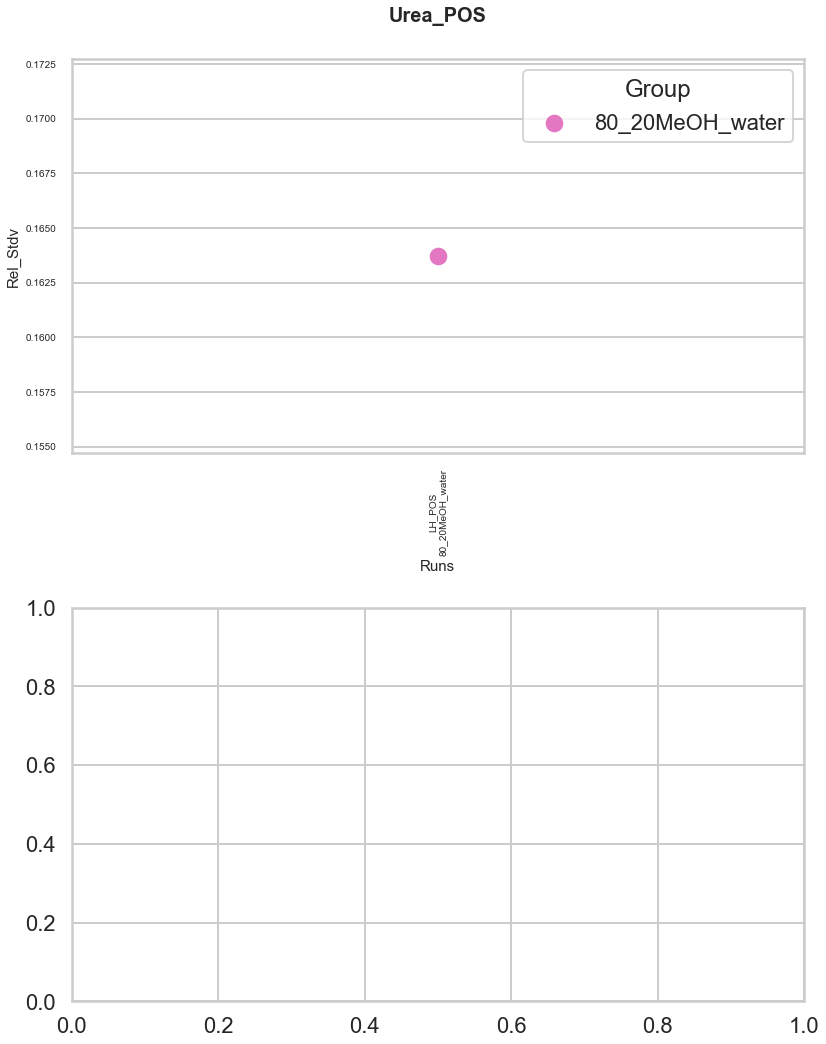

QCserum
POS
20water_60MeOH
60_20AcN_water_AmCab_pH9
60_20AcN_water_AmForm_pH3
60_20isopropanol_water_AmCab_pH9
60_20isopropanol_water_AmFor_pH3
80_20AcN_water
80_20MeOH_water
         Metabolite          Mean      Variance  Rel_Stdv  \
5  HMDB:HMDB0000294  4.142134e+06  2.711289e+10  0.039752   
4  HMDB:HMDB0000294  2.574523e+05  5.913276e+08  0.094453   
5  HMDB:HMDB0000294  1.098303e+07  1.484083e+11  0.035076   

                                                 Run  \
5           LH_POS\n60_20isopropanol_water_AmFor_pH3   
4  OldSourceSettings_LH_POS\n60_20isopropanol_wat...   
5                            LH_POS\n80_20MeOH_water   

                              Group  
5  60_20isopropanol_water_AmFor_pH3  
4  60_20isopropanol_water_AmFor_pH3  
5                   80_20MeOH_water  


ValueError: Invalid RGBA argument: 0.5803921568627451

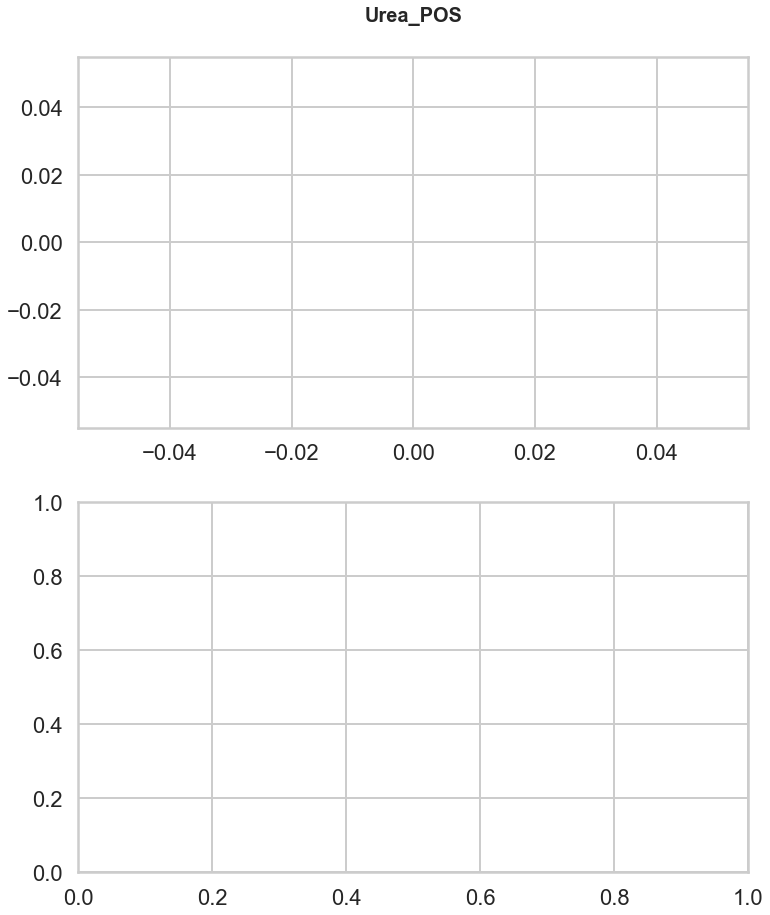

In [72]:
param = 'Rel_Stdv' # 'Mean'

for index, rows in translator.iterrows():
    metabolite = [rows.DB, rows.Name] 
    file_counter = 0
    for file in stats_files2:
        for sample_type in sample_types:
            print(sample_type)
            sns.set_context("poster")
            f, axs = plt.subplots(len(charges), 1, figsize=(12, 15), gridspec_kw={'width_ratios': [5]})
            cmap = sns.cubehelix_palette(as_cmap=True, n_colors=200)
            i = 0
            for charge in charges:
                print(charge)
                results_collection = []
                sum_file = pd.concat(file)
                for solvent in solvents:
                    names_collection = []
                    for name in list(sum_file.index):
                        names_collection.append(name[0])
                    for method in methods:
                        for setting in settings:
                            if setting == 'NewSourceSettings':
                                run_name = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + method + '_' + charge
                                abbrv_name = method + '_' + charge + '\n' + solvent
                            else:
                                run_name = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + method + '_' + charge
                                abbrv_name = setting + '_' + method + '_' + charge + '\n' + solvent
                            if run_name in names_collection:
                                run_data = copy.deepcopy(sum_file.loc[run_name,:])
                                run_data.loc[:,'Run'] = abbrv_name
                                run_data.loc[:,'Group'] = solvent
                                results_collection.append(run_data)
                    print(solvent)
                results_collection = pd.concat(results_collection)
                ts = [k for k, x in enumerate(results_collection['Metabolite'] == metabolite[0]) if x]
                if len(ts) > 0:
                    results_collection = results_collection.iloc[ts,:]
                    axs[i].set_title(metabolite[1] + '_' + charge, fontweight="bold", size=20, y=1.08) # Title
                    sns.set_style("whitegrid")
                    print(results_collection)
                    sns.pointplot(x="Run", y=param, hue='Group', data=results_collection, join=False, linewidth=2, ax=axs[i],
                                  cmap=cmap, palette=palette)
                    axs[i].tick_params('x', labelrotation=90, labelsize = 10)
                    axs[i].tick_params('y', labelrotation=0, labelsize = 10)
                    axs[i].set_xlabel('Runs', fontsize=15)
                    axs[i].set_ylabel(param, fontsize=15)
                    plt.tight_layout()
                i += 1
            plt.show()
            #f.savefig('Metabolite_Plots/' + param + '_' + file_names[file_counter] + '_' + sample_type + '_' + metabolite[1] + '.pdf')
        file_counter += 1

([], [])

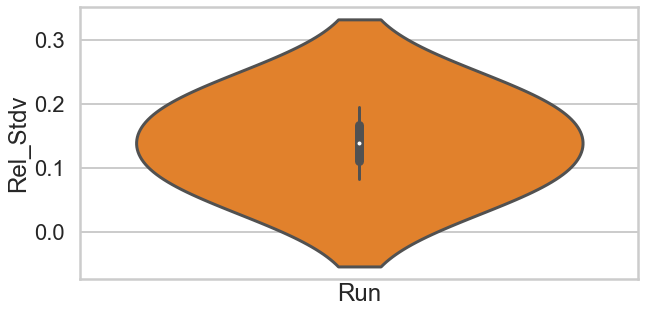

In [50]:
sum_file = pd.concat(stats_files2[0], axis=0, join='outer', ignore_index=False, keys=None,
                                          levels=None, names=None, verify_integrity=False, copy=True)
a = '20200618_Blank_NewSourceSettings_20water_60MeOH_M_0_2sWaste_NEG'
c = sum_file.loc[a,:]
plt.figure(figsize=(10,5))
sns.violinplot(x="Run", y="Rel_Stdv", data=c, orient = 'v', color="C1")
plt.xticks([])

In [65]:
file_iterator = 0
for files in stats_files2:
    print(file_names[file_iterator])
    for sample_type in sample_types:
        print(sample_type)
        a = pd.concat(files, axis=0, join='outer', ignore_index=False, keys=None,
              levels=None, names=None, verify_integrity=False, copy=True)
        #for run in a['Run']:
            #if sample_type in run:
                #print(run)
                #plt.figure(figsize=(10,5))
                #sns.violinplot(x="Run", y="Rel_Stdv", data=a, orient = 'v')
                #plt.xticks([])
                #plt.show()
    file_iterator += 1

30sec
Blank
QCserum
60sec
Blank
QCserum
90sec
Blank
QCserum
180sec
Blank
QCserum


In [374]:
a = pd.concat(stats_files2[0], join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

In [46]:
SerumTop10 = pd.read_csv("/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/traML.csv", 
                                 sep="\,", header=None, engine='python')
DB = list(SerumTop10.iloc[:,0])[1:]
Name = list(SerumTop10.iloc[:,3])[1:]
trans = {'DB': DB, 'Name': Name}

translator = pd.DataFrame(trans)
"""
j = 0
name_list = []
for each in a['Metabolite']:
    i = 0
    for trans in translator['DB']:
        if each == trans:
            name_list.append(list(translator['Name'])[i])
        i += 1
    j += 1"""

"\nj = 0\nname_list = []\nfor each in a['Metabolite']:\n    i = 0\n    for trans in translator['DB']:\n        if each == trans:\n            name_list.append(list(translator['Name'])[i])\n        i += 1\n    j += 1"

In [49]:
for db_code in translator['DB']:
    print(db_code)

HMDB:HMDB0000294
HMDB:HMDB0000190
HMDB:HMDB0000289
HMDB:HMDB0004068
HMDB:HMDB0002030
HMDB:HMDB0001875
HMDB:HMDB0000641
HMDB:HMDB0000067
HMDB:HMDB0000182
HMDB:HMDB0000122
HMDB:HMDB0000161
HMDB:HMDB0000123


([], [])

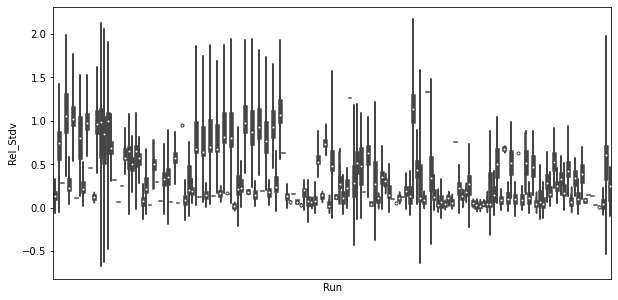

In [358]:
plt.figure(figsize=(10,5))
sns.violinplot(x="Run", y="Rel_Stdv", data=a, orient = 'v')
plt.xticks([])

([], [])

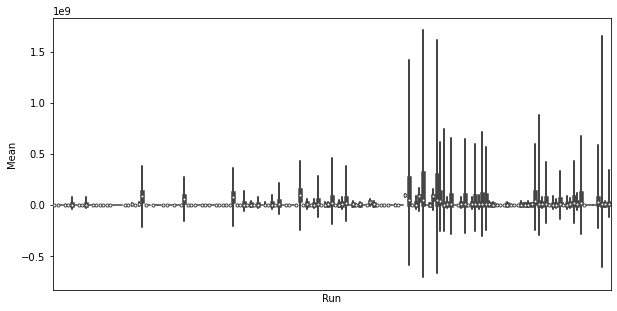

In [359]:
plt.figure(figsize=(10,5))
sns.violinplot(x="Run", y="Mean", data=a, orient = 'v')
plt.xticks([])